# Flight Delay Prediction Pipeline

## Objectives
1. **Data Loading**: Load flight and plane data.
2. **Variable Selection & Transformation**: Clean data, handle missing values, and transform features.
3. **Feature Engineering**: Create derived variables (e.g., Polar coordinates for time).
4. **Model Training**: Train Regression models (Linear, Decision Tree, Random Forest) to predict `ArrDelay`.
5. **Validation**: Evaluate models using RMSE, MAE, and R2.
6. **Artifact Storage**: Save the **Best Model** and **Preprocessing Parameters** for the production app.

In [1]:
# =================== 1. Setup & Imports ===================
import os
import shutil
import json
import logging
import sys
from math import pi, cos, sin

# PySpark Imports
from pyspark.sql import SparkSession, DataFrame, functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, StructType
from pyspark.sql.functions import col, lit, when, udf, count, avg
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import VectorUDT

# Setup Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Initialize Spark
spark = (SparkSession.builder.appName("FlightDelayTraining")
         .config("spark.executor.memory", "4g")
         .config("spark.driver.memory", "8g")
         .config("spark.sql.caseSensitive", "true")
         .getOrCreate())
spark.sparkContext.setLogLevel("WARN")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/07 22:36:16 WARN Utils: Your hostname, MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.162 instead (on interface en0)
26/01/07 22:36:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/07 22:36:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# =================== 2. Configuration ===================
import os
import glob

# 1. Get the absolute path to the data directory
current_dir = os.path.abspath(".")
flight_data_dir = os.path.join(current_dir, "training_data", "flight_data")

# 2. Use Python to find the files (Bypasses Spark wildcard issues)
flight_files = glob.glob(os.path.join(flight_data_dir, "*.csv.bz2"))

# Debug print
print(f"DEBUG: Found {len(flight_files)} flight data files.")
if not flight_files:
    raise RuntimeError(f"No .csv.bz2 files found in {flight_data_dir}. Check your folders!")

# 3. Assign the LIST of files to the variable
# Spark accepts a list of file paths perfectly fine
FLIGHT_RAW_PATH = flight_files

# 4. Plane data path (Absolute path)
PLANE_RAW_PATH = os.path.join(flight_data_dir, "plane-data.csv")

# Output/Intermediate Paths
DATA_DIR = "./data/"
TEMP_DIR = "./data/temp/"
BEST_MODEL_DIR = "best_model/"
PROCESSING_PARAMS_DIR = os.path.join(BEST_MODEL_DIR, "processing/")

# Ensure directories exist
for path in [DATA_DIR, TEMP_DIR, BEST_MODEL_DIR, PROCESSING_PARAMS_DIR]:
    os.makedirs(path, exist_ok=True)

DEBUG: Found 4 flight data files.


## 3. Data Loader Class
Handles reading raw CSVs, inferring schema, and caching to Parquet for speed.

In [3]:
class DataLoader:
    def __init__(self, spark, temp_dir):
        self.spark = spark
        self.temp_dir = temp_dir

    def load_csv_and_cache(self, raw_path, name):
        """
        Reads CSV, infers schema, saves to Parquet, and reloads.
        """
        parquet_path = os.path.join(self.temp_dir, f"{name}.parquet")
        
        if os.path.exists(parquet_path):
            logger.info(f"Loading cached data from {parquet_path}")
            return self.spark.read.parquet(parquet_path)

        logger.info(f"Reading raw data from {raw_path}...")
        df = self.spark.read.csv(raw_path, header=True, inferSchema=True, nullValue="NA")
        
        # Save to parquet
        df.write.mode("overwrite").parquet(parquet_path)
        return self.spark.read.parquet(parquet_path)

## 4. Preprocessor Class (Selection & Transformation)
This class encapsulates:
1. **Static Transformation**: Cleaning, Casting, Drop forbidden columns, Polar Time encoding.
2. **Fit (Training Only)**: Learn medians, modes, and target encoding maps from training data and save them.
3. **Dynamic Transformation**: Apply the learned parameters to any dataframe.

In [4]:
class Preprocessor:
    def __init__(self, params_dir):
        self.params_dir = params_dir
        self.cyclic_ordinal_time = ['Month', 'DayofMonth', 'DayOfWeek']
        self.quant_time_features = ['DepTime', 'CRSDepTime', 'CRSArrTime']
        self.quantitative_features = ['CRSElapsedTime', 'DepDelay', 'Distance', 'TaxiOut']
        self.nominal_features = [
            'UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest', 'Cancelled',
            'CancellationCode', 'EngineType', 'AircraftType', 'Manufacturer', 'Model',
            "issue_date", "status", "type"
        ]
        self.non_cyclic_ordinal_time = ['Year', 'PlaneIssueYear']

    def _cast_columns_safely(self, df, columns, target_type="int"):
        for col_name in columns:
            df = df.withColumn(col_name, F.expr(f"try_cast({col_name} as {target_type})"))
        return df

    def _polar_time_encode(self, df):
        logger.info("Applying polar encoding to time features...")
        def polar_calc(value, max_val):
            if value is None: return None, None
            angle = (value / max_val) * 2 * pi
            return float(cos(angle)), float(sin(angle))
        
        polar_udf = udf(polar_calc, "struct<cos:double, sin:double>")
        df = df.withColumn("Month_polar", polar_udf(col("Month"), lit(12))) \
            .withColumn("DayofMonth_polar", polar_udf(col("DayofMonth"),
                                                      when(col("Month") == 2, lit(28))
                                                      .when(col("Month").isin([4, 6, 9, 11]), lit(30))
                                                      .otherwise(lit(31)))) \
            .withColumn("DayOfWeek_polar", polar_udf(col("DayOfWeek"), lit(7)))

        for base in ["Month", "DayofMonth", "DayOfWeek"]:
            df = df.withColumn(f"{base}_cos", col(f"{base}_polar.cos")) \
                   .withColumn(f"{base}_sin", col(f"{base}_polar.sin"))
        return df.drop("Month_polar", "DayofMonth_polar", "DayOfWeek_polar")

    def static_transform(self, df_flights, df_planes):
        logger.info("Starting static preprocessing...")
        # Join Planes
        df_planes = df_planes.withColumnRenamed("tailnum", "TailNum")
        df = df_flights.join(df_planes, on="TailNum", how="inner")
        
        # Filter Cancelled
        df = df.withColumn("Cancelled", col("Cancelled").cast("string"))
        df = df.filter(col("Cancelled") != "1")

        # Drop Forbidden / Useless
        forbidden = ["ArrTime", "ActualElapsedTime", "AirTime", "TaxiIn", "Diverted", 
                     "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay"]
        useless = ["TailNum", "FlightNum", "UniqueCarrier", "CancellationCode", "Cancelled", 
                   "issue_date", "status", "type"]
        df = df.drop(*(forbidden + useless))

        # Rename
        rename_map = {"year": "PlaneIssueYear", "engine_type": "EngineType", 
                      "aircraft_type": "AircraftType", "model": "Model", "manufacturer": "Manufacturer"}
        for old, new in rename_map.items():
            df = df.withColumnRenamed(old, new)

        # Safe Casting
        target_col = "ArrDelay"
        cols_to_cast = self.quantitative_features + [target_col]
        df = self._cast_columns_safely(df, cols_to_cast, "int")
        df = df.dropna(subset=[target_col])

        # Time Processing
        for t_col in self.quant_time_features:
            df = df.withColumn(t_col, when(F.trim(col(t_col)) == "NA", None).otherwise(col(t_col)))
            df = df.withColumn(f"{t_col}_minutes", 
                               (F.expr(f"try_cast(substring({t_col}, 1, 2) as int)") * 60 + 
                                F.expr(f"try_cast(substring({t_col}, 3, 2) as int)"))).fillna(0)
            self.quantitative_features.append(f"{t_col}_minutes")
        df = df.drop(*self.quant_time_features)

        # Polar Encoding
        df = self._polar_time_encode(df)
        ordinal_feats = [f"{f}_{s}" for f in self.cyclic_ordinal_time for s in ['sin', 'cos']]
        final_nominal = ["Origin", "Dest", "EngineType", "AircraftType", "Manufacturer", "Model"]
        
        return df, self.quantitative_features, ordinal_feats, final_nominal + self.non_cyclic_ordinal_time

    def fit(self, df, nominal, ordinal, quantitative):
        """
        Learns parameters (medians, modes, encodings) and saves them.
        """
        logger.info("Learning preprocessing parameters...")
        imputer_maps = {}
        
        # Medians for Quantitative
        for fea in quantitative:
            median = df.approxQuantile(col=fea, probabilities=[0.5], relativeError=0.025)[0]
            imputer_maps[fea] = {'extra_nulls': [], 'fill_value': median}

        # Modes for Categorical
        for fea in ordinal + nominal:
            mode_row = df.groupby(fea).count().orderBy("count", ascending=False).first()
            fill_val = mode_row[0] if mode_row else 0
            imputer_maps[fea] = {'extra_nulls': ['None'], 'fill_value': fill_val}
            
        with open(os.path.join(self.params_dir, 'imputer_maps.json'), 'w') as f:
            json.dump(imputer_maps, f, indent=4)

        # Nominal Encoding Logic
        feature_to_frequent = {}
        encode_types = {}
        new_nominal = []
        total = df.count()

        for fea in nominal:
            # Frequency Threshold
            freq_rows = df.groupBy(fea).agg((count("*")/total).alias("freq")) \
                          .filter(col("freq") > 0.02).select(fea).collect()
            valid_cats = [row[fea] for row in freq_rows]
            feature_to_frequent[fea] = valid_cats
            
            # Create aggregated temp column
            df_temp = df.withColumn(f"{fea}_agg", when(col(fea).isin(valid_cats), col(fea)).otherwise(lit("Other")))
            
            if len(valid_cats) + 1 <= 10: # Low Cardinality -> OHE
                logger.info(f"Encoding {fea} as OneHot")
                indexer = StringIndexer(inputCol=f"{fea}_agg", outputCol=f"{fea}_idx", handleInvalid='keep')
                encoder = OneHotEncoder(inputCol=f"{fea}_idx", outputCol=f"{fea}_bin", dropLast=True)
                Pipeline(stages=[indexer, encoder]).fit(df_temp).save(os.path.join(self.params_dir, f'{fea}_encoder'))
                encode_types[f"{fea}_agg"] = "binary"
                new_nominal.append(f"{fea}_bin")
            else: # High Cardinality -> Mean Target
                logger.info(f"Encoding {fea} as MeanTarget")
                mapping = df_temp.groupBy(f"{fea}_agg").agg(avg("ArrDelay").alias("mean_enc"))
                mapping.write.mode("overwrite").csv(os.path.join(self.params_dir, f'{fea}_mean_map.csv'), header=True)
                encode_types[f"{fea}_agg"] = "mean"
                new_nominal.append(f"{fea}_mean_enc")

        with open(os.path.join(self.params_dir, 'encode_types.json'), 'w') as f: json.dump(encode_types, f)
        with open(os.path.join(self.params_dir, 'non_aggregated.json'), 'w') as f: json.dump(feature_to_frequent, f)
        
        final_features = quantitative + ordinal + new_nominal
        with open(os.path.join(self.params_dir, 'feature_columns.json'), 'w') as f: json.dump(final_features, f)
        logger.info("Training parameters saved.")

    def dynamic_transform(self, df, nominal, ordinal, quantitative):
        """
        Applies saved parameters to the dataframe.
        """
        logger.info("Applying dynamic transformation...")
        
        # 1. Imputer
        with open(os.path.join(self.params_dir, 'imputer_maps.json')) as f: maps = json.load(f)
        for fea in quantitative + ordinal + nominal:
            if fea in df.columns:
                fill_val = maps[fea]['fill_value']
                df = df.fillna(fill_val, subset=[fea])

        # 2. Encoding
        with open(os.path.join(self.params_dir, 'encode_types.json')) as f: enc_types = json.load(f)
        with open(os.path.join(self.params_dir, 'non_aggregated.json')) as f: freqs = json.load(f)

        for fea, cats in freqs.items():
            if fea in df.columns:
                df = df.withColumn(f"{fea}_agg", when(col(fea).isin(cats), col(fea)).otherwise(lit("Other")))

        for agg_fea, method in enc_types.items():
            orig = agg_fea.replace("_agg", "")
            if method == 'binary':
                model = PipelineModel.load(os.path.join(self.params_dir, f'{orig}_encoder'))
                df = model.transform(df)
            elif method == 'mean':
                mapping = spark.read.csv(os.path.join(self.params_dir, f'{orig}_mean_map.csv'), header=True, inferSchema=True)
                df = df.join(mapping.withColumnRenamed("mean_enc", f"{orig}_mean_enc"), on=agg_fea, how='left')
                df = df.fillna(0, subset=[f"{orig}_mean_enc"]) # Fill unknown with 0 or global mean

        # 3. Vector Assembler
        with open(os.path.join(self.params_dir, 'feature_columns.json')) as f: cols = json.load(f)
        avail_cols = [c for c in cols if c in df.columns]
        df = VectorAssembler(inputCols=avail_cols, outputCol="features", handleInvalid="skip").transform(df)
        return df

## 5. Execution Pipeline
1. Load Data
2. Static Preprocess
3. Split Data
4. **Learn Parameters (Fit)** on Train Data
5. **Apply Parameters (Transform)** on Train and Test
6. Model Training & Evaluation

In [5]:
# 1. Load Data
loader = DataLoader(spark, TEMP_DIR)
df_flights = loader.load_csv_and_cache(FLIGHT_RAW_PATH, "flights")
df_planes = loader.load_csv_and_cache(PLANE_RAW_PATH, "planes")

# 2. Static Preprocess (Clean & Join)
prep = Preprocessor(PROCESSING_PARAMS_DIR)
df_clean, quant_feats, ord_feats, nom_feats = prep.static_transform(df_flights, df_planes)

# 3. Split Data
train_df, test_df = df_clean.randomSplit([0.8, 0.2], seed=42)

# 4. Fit Preprocessor (Learn from Train)
prep.fit(train_df, nom_feats, ord_feats, quant_feats)

# 5. Transform Both
train_final = prep.dynamic_transform(train_df, nom_feats, ord_feats, quant_feats)
test_final = prep.dynamic_transform(test_df, nom_feats, ord_feats, quant_feats)

# Cache for performance during training
train_final.cache()
test_final.cache()

2026-01-07 22:36:32,332 - INFO - Reading raw data from ['/Users/cristian/Documents/GitHub/big_data_flight_delay/training_data/flight_data/1988.csv.bz2', '/Users/cristian/Documents/GitHub/big_data_flight_delay/training_data/flight_data/1999.csv.bz2', '/Users/cristian/Documents/GitHub/big_data_flight_delay/training_data/flight_data/2006.csv.bz2', '/Users/cristian/Documents/GitHub/big_data_flight_delay/training_data/flight_data/2008.csv.bz2']...
26/01/07 22:36:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
2026-01-07 22:37:12,230 - INFO - Reading raw data from /Users/cristian/Documents/GitHub/big_data_flight_delay/training_data/flight_data/plane-data.csv...
2026-01-07 22:37:12,523 - INFO - Starting static preprocessing...
2026-01-07 22:37:12,959 - INFO - Applying polar encoding to time features...
2026-01-07 22:37:13,081 - INFO - Learning preprocessing parameters.

DataFrame[PlaneIssueYear_agg: string, Model_agg: string, Dest_agg: string, Origin_agg: string, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, CRSElapsedTime: int, ArrDelay: int, DepDelay: int, Origin: string, Dest: string, Distance: int, TaxiOut: int, Manufacturer: string, Model: string, AircraftType: string, EngineType: string, PlaneIssueYear: string, DepTime_minutes: int, CRSDepTime_minutes: int, CRSArrTime_minutes: int, Month_cos: double, Month_sin: double, DayofMonth_cos: double, DayofMonth_sin: double, DayOfWeek_cos: double, DayOfWeek_sin: double, EngineType_agg: string, AircraftType_agg: string, Manufacturer_agg: string, Year_agg: bigint, Origin_mean_enc: double, Dest_mean_enc: double, EngineType_idx: double, EngineType_bin: vector, AircraftType_idx: double, AircraftType_bin: vector, Manufacturer_idx: double, Manufacturer_bin: vector, Model_mean_enc: double, Year_idx: double, Year_bin: vector, PlaneIssueYear_mean_enc: double, features: vector]

## 6. Model Training & Validation
We will train a **Linear Regression** and a **Random Forest** model. 
We use `StandardScaler` to normalize features for Linear Regression.
The best model will be saved.

In [6]:
def train_and_evaluate(train_data, test_data, save_path):
    # --- 1. Define Candidate Models ---
    # Linear Regression (Baseline)
    lr = LinearRegression(featuresCol="features", labelCol="ArrDelay", regParam=0.1)
    
    # Decision Tree (Simple Non-Linear)
    dt = DecisionTreeRegressor(featuresCol="features", labelCol="ArrDelay", maxDepth=5)
    
    # Random Forest (Ensemble Bagging - Parallel)
    rf = RandomForestRegressor(featuresCol="features", labelCol="ArrDelay", numTrees=20, maxDepth=10)
    
    # Gradient Boosted Trees (Ensemble Boosting - Sequential)
    # Note: GBT is often slower to train but very accurate
    gbt = GBTRegressor(featuresCol="features", labelCol="ArrDelay", maxIter=10)
    
    models = {
        "LinearRegression": lr,
        "DecisionTree": dt,
        "RandomForest": rf,
        "GBTRegressor": gbt
    }
    
    # --- 2. Training Loop ---
    best_metric = float('inf') # We want to minimize RMSE
    best_model = None
    best_name = ""
    
    results = {}

    print(f"{'Model':<20} | {'RMSE':<10} | {'MAE':<10} | {'R2':<10}")
    print("-" * 60)

    for name, model in models.items():
        # Fit
        trained_model = model.fit(train_data)
        
        # Predict
        predictions = trained_model.transform(test_data)
        
        # Evaluate
        evaluator_rmse = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="rmse")
        evaluator_mae = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="mae")
        evaluator_r2 = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="r2")
        
        rmse = evaluator_rmse.evaluate(predictions)
        mae = evaluator_mae.evaluate(predictions)
        r2 = evaluator_r2.evaluate(predictions)
        
        # Log Result
        print(f"{name:<20} | {rmse:<10.4f} | {mae:<10.4f} | {r2:<10.4f}")
        results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}
        
        # Track Best
        if rmse < best_metric:
            best_metric = rmse
            best_model = trained_model
            best_name = name

    print("-" * 60)
    print(f"Winner: {best_name} (RMSE: {best_metric:.4f})")

    # --- 3. Save as Pipeline (Fixes 'stageUids' Error) ---
    # We wrap the model in a PipelineModel so .load() works generically later
    final_pipeline = PipelineModel(stages=[best_model])
    
    full_save_path = os.path.join(save_path, "retrained_best_model")
    
    # Overwrite if exists
    final_pipeline.write().overwrite().save(full_save_path)
    logger.info(f"Saved best model ({best_name}) to {full_save_path}")
    
    # --- 4. Return the Winner Name ---
    return best_name

winner_name = train_and_evaluate(train_final, test_final, BEST_MODEL_DIR)
print(f"The variable 'winner_name' is now set to: {winner_name}")

Model                | RMSE       | MAE        | R2        
------------------------------------------------------------


26/01/07 22:43:41 WARN MemoryStore: Not enough space to cache rdd_952_3 in memory! (computed 107.1 MiB so far)
26/01/07 22:43:41 WARN BlockManager: Persisting block rdd_952_3 to disk instead.
26/01/07 22:43:41 WARN MemoryStore: Not enough space to cache rdd_952_2 in memory! (computed 107.3 MiB so far)
26/01/07 22:43:41 WARN BlockManager: Persisting block rdd_952_2 to disk instead.
26/01/07 22:43:41 WARN MemoryStore: Not enough space to cache rdd_952_10 in memory! (computed 211.4 MiB so far)
26/01/07 22:43:41 WARN BlockManager: Persisting block rdd_952_10 to disk instead.
26/01/07 22:43:43 WARN MemoryStore: Not enough space to cache rdd_952_0 in memory! (computed 211.0 MiB so far)
26/01/07 22:43:43 WARN BlockManager: Persisting block rdd_952_0 to disk instead.
26/01/07 22:43:43 WARN MemoryStore: Not enough space to cache rdd_952_4 in memory! (computed 211.2 MiB so far)
26/01/07 22:43:43 WARN BlockManager: Persisting block rdd_952_4 to disk instead.
26/01/07 22:43:43 WARN MemoryStore: No

LinearRegression     | 12.2543    | 7.7786     | 0.8906    


26/01/07 22:44:17 WARN MemoryStore: Not enough space to cache rdd_952_3 in memory! (computed 366.8 MiB so far)
26/01/07 22:44:17 WARN MemoryStore: Not enough space to cache rdd_952_1 in memory! (computed 367.2 MiB so far)
26/01/07 22:44:17 WARN MemoryStore: Not enough space to cache rdd_952_2 in memory! (computed 366.9 MiB so far)
26/01/07 22:44:18 WARN MemoryStore: Not enough space to cache rdd_952_10 in memory! (computed 367.4 MiB so far)
26/01/07 22:44:19 WARN MemoryStore: Not enough space to cache rdd_952_2 in memory! (computed 366.9 MiB so far)
26/01/07 22:44:19 WARN MemoryStore: Not enough space to cache rdd_952_1 in memory! (computed 367.2 MiB so far)
26/01/07 22:44:19 WARN MemoryStore: Not enough space to cache rdd_952_10 in memory! (computed 367.4 MiB so far)
26/01/07 22:44:19 WARN MemoryStore: Not enough space to cache rdd_952_3 in memory! (computed 366.8 MiB so far)
26/01/07 22:44:21 WARN MemoryStore: Not enough space to cache rdd_952_1 in memory! (computed 211.2 MiB so far)

DecisionTree         | 17.2702    | 9.7758     | 0.7827    


26/01/07 22:44:29 WARN MemoryStore: Not enough space to cache rdd_952_2 in memory! (computed 366.9 MiB so far)
26/01/07 22:44:29 WARN MemoryStore: Not enough space to cache rdd_952_3 in memory! (computed 366.8 MiB so far)
26/01/07 22:44:29 WARN MemoryStore: Not enough space to cache rdd_952_1 in memory! (computed 367.2 MiB so far)
26/01/07 22:44:29 WARN MemoryStore: Not enough space to cache rdd_952_10 in memory! (computed 367.4 MiB so far)
26/01/07 22:44:31 WARN MemoryStore: Not enough space to cache rdd_952_3 in memory! (computed 366.8 MiB so far)
26/01/07 22:44:31 WARN MemoryStore: Not enough space to cache rdd_952_2 in memory! (computed 366.9 MiB so far)
26/01/07 22:44:31 WARN MemoryStore: Not enough space to cache rdd_952_10 in memory! (computed 367.4 MiB so far)
26/01/07 22:44:31 WARN MemoryStore: Not enough space to cache rdd_952_1 in memory! (computed 367.2 MiB so far)
26/01/07 22:44:32 WARN MemoryStore: Not enough space to cache rdd_1166_7 in memory! (computed 12.0 MiB so far)

RandomForest         | 15.1394    | 9.0750     | 0.8330    


26/01/07 22:45:36 WARN MemoryStore: Not enough space to cache rdd_952_1 in memory! (computed 367.2 MiB so far)
26/01/07 22:45:36 WARN MemoryStore: Not enough space to cache rdd_952_3 in memory! (computed 366.8 MiB so far)
26/01/07 22:45:36 WARN MemoryStore: Not enough space to cache rdd_952_10 in memory! (computed 367.4 MiB so far)
26/01/07 22:45:36 WARN MemoryStore: Not enough space to cache rdd_952_7 in memory! (computed 366.8 MiB so far)
26/01/07 22:45:36 WARN MemoryStore: Not enough space to cache rdd_952_5 in memory! (computed 366.7 MiB so far)
26/01/07 22:45:36 WARN MemoryStore: Not enough space to cache rdd_952_2 in memory! (computed 574.6 MiB so far)
26/01/07 22:45:38 WARN MemoryStore: Not enough space to cache rdd_952_5 in memory! (computed 366.7 MiB so far)
26/01/07 22:45:38 WARN MemoryStore: Not enough space to cache rdd_952_10 in memory! (computed 367.4 MiB so far)
26/01/07 22:45:38 WARN MemoryStore: Not enough space to cache rdd_952_1 in memory! (computed 367.2 MiB so far)

GBTRegressor         | 16.8778    | 9.3042     | 0.7925    
------------------------------------------------------------
Winner: LinearRegression (RMSE: 12.2543)


2026-01-07 22:46:11,740 - INFO - Saved best model (LinearRegression) to best_model/retrained_best_model


The variable 'winner_name' is now set to: LinearRegression


## 7. Generate Validation Predictions (CSV)
Generating a sample CSV output for inspection, ensuring Vector columns are removed.

In [7]:
# Load the standard path (we standardized the name in step 3 to "retrained_best_model")
model_path = os.path.join(BEST_MODEL_DIR, "retrained_best_model")
loaded_model = PipelineModel.load(model_path)

logger.info(f"Loaded the winner model: {winner_name}")

# Generate Predictions
predictions = loaded_model.transform(test_final)

# Select columns for CSV (Drop Vectors to avoid crashes)
cols_to_save = []
for field in predictions.schema.fields:
    if not isinstance(field.dataType, VectorUDT) and field.name != 'scaledFeatures':
        cols_to_save.append(field.name)

# Save
output_csv = "./data/output_predictions.csv"
predictions.select(cols_to_save).limit(100).write.mode("overwrite").option("header", "true").csv(output_csv)
print(f"Sample predictions saved using the {winner_name} model.")

2026-01-07 22:50:12,709 - INFO - Loaded the winner model: LinearRegression


Sample predictions saved using the LinearRegression model.


Generating Evidence Graphs...


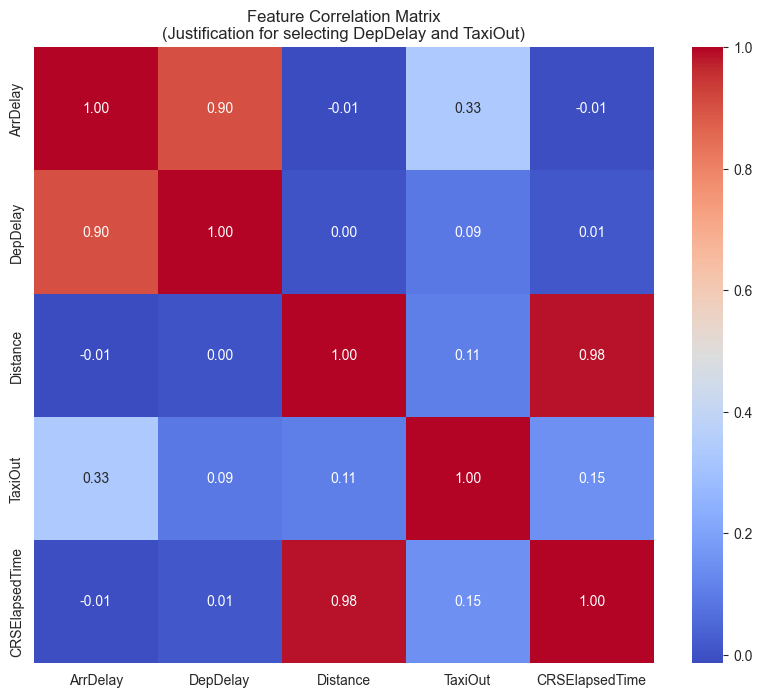

/var/folders/nh/fj6gh87d1nj8xz4w9_l7_q2r0000gn/T/ipykernel_39023/1503884070.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf_null, x='Missing_Count', y='Feature', palette='viridis')


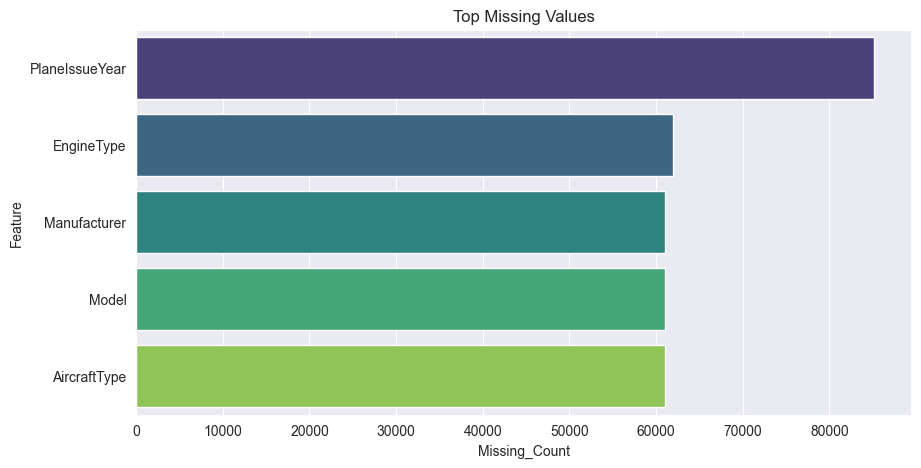

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import StringType
import pyspark.sql.functions as F  # Ensure F is available

def generate_evidence_graphs(df):
    print("Generating Evidence Graphs...")
    
    # --- 1. Correlation Matrix ---
    # List of ideal columns we WANT to check
    desired_cols = ['ArrDelay', 'DepDelay', 'Distance', 'TaxiOut', 'CRSElapsedTime']
    
    # FILTER: Create a list of columns that ACTUALLY exist in the provided dataframe
    numeric_cols = [c for c in desired_cols if c in df.columns]
    
    # Check if we have enough data to make a plot (at least 2 columns)
    if len(numeric_cols) >= 2:
        # Assemble only the existing columns
        assembler = VectorAssembler(inputCols=numeric_cols, outputCol="corr_features")
        
        # Transform and select
        # dropna() is added to ensure correlation doesn't fail on nulls
        df_vector = assembler.transform(df.dropna(subset=numeric_cols)).select("corr_features")
        
        # Calculate Correlation
        matrix = Correlation.corr(df_vector, "corr_features").head()[0]
        corr_array = matrix.toArray()
        
        # Plotting
        plt.figure(figsize=(10, 8))
        # Use numeric_cols for labels so they match the data exactly
        sns.heatmap(corr_array, annot=True, fmt=".2f", cmap='coolwarm', 
                    xticklabels=numeric_cols, yticklabels=numeric_cols)
        plt.title("Feature Correlation Matrix")
        plt.show()
    else:
        print(f"Skipping Correlation Matrix: Not enough numeric columns found from list {desired_cols}")

    # --- 2. Missing Values Analysis ---
    null_counts = []
    for col_name in df.columns:
        # Define base NULL check
        cond = F.col(col_name).isNull()
        
        # ONLY check for "NA" string if the column is actually a StringType
        dtype = df.schema[col_name].dataType
        if isinstance(dtype, StringType):
            cond = cond | (F.col(col_name) == "NA") | (F.col(col_name) == "None")
        
        # Filter and count
        count = df.filter(cond).count()
        
        if count > 0:
            null_counts.append({'Feature': col_name, 'Missing_Count': count})
            
    if null_counts:
        import pandas as pd
        pdf_null = pd.DataFrame(null_counts).sort_values('Missing_Count', ascending=False).head(10)
        
        plt.figure(figsize=(10, 5))
        sns.barplot(data=pdf_null, x='Missing_Count', y='Feature', palette='viridis')
        plt.title("Top Missing Values")
        plt.show()

# --- EXECUTE IN NOTEBOOK ---
# Now this will work even if 'Distance' was dropped
generate_evidence_graphs(df_clean.sample(fraction=0.1))